## 生成训练所用的数据，包括：
* 直线上等距离取线段后，所获取到的 dem aspect degree 对应的三个值，每个值，包含临近 3 * 3 范围内的值
### 注意：这里用到的环境是 ML python=3.9，而原来进行路径规划所用到的为 pytorch_env python=3.8
如果出现了问题，留意这里环境的切换

In [85]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
from shapely import Point, LineString, Polygon
import ast

In [86]:
# 读取数据并且预处理，消除 nodata 值，更改为 0
with rasterio.open('GIS_data/路径规划优化用数据/2m_pClouds_regen_dem_cm.tif') as dem_src:  # dem
    dem_array = dem_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_cm1.tif') as aspect_src:  # 坡向
    aspect_array = aspect_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif') as slope_src:  # 坡度
    slope_array = slope_src.read(1)
# 加载路径，这里加载的是直线路径，模拟路径规划算法出来的 scanline 路径，如果后续需要，也可以用到论文中的 cylinder method 生成路径
straight_paths = gpd.read_file('GIS_data/straight_swaths/straight_swaths.shp')

<AxesSubplot: >

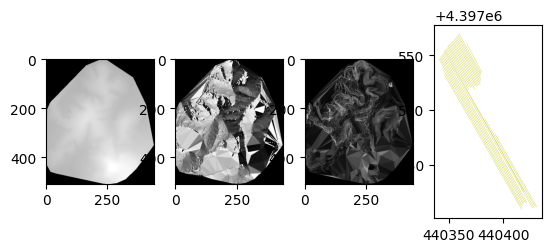

In [87]:
# 预处理
dem_array[dem_array == dem_array.min()] = 0
aspect_array[aspect_array == aspect_array.min()] = 0
slope_array[slope_array == slope_array.min()] = 0

# 验证一下
_, ax = plt.subplots(ncols=4, nrows=1)
ax1, ax2, ax3, ax4 = ax[0], ax[1], ax[2], ax[3]
ax1.imshow(dem_array, cmap='gray')
ax2.imshow(aspect_array, cmap='gray')
ax3.imshow(slope_array, cmap='gray')
straight_paths.plot(ax=ax4, color='y', linewidth=0.2)

### 对 直线路径（规划路径）按照采样精度进行采样

In [88]:
# 数据采集的精度，单位 m
step_length = 1
all_sample_points = []
for single_straight_swath in straight_paths.geometry:
    sample_points = np.arange(0, single_straight_swath.length, step_length)
    all_sample_points += [single_straight_swath.interpolate(sample_point) for sample_point in sample_points]
print("总采样点数：", len(all_sample_points))
print(type(all_sample_points[0]))
print(all_sample_points[0])

总采样点数： 2428
<class 'shapely.geometry.point.Point'>
POINT (440345.93409065274 4397532.697626984)


#### 对每一个 sample_point 进行邻域 3 * 3 的采样

In [89]:
# 创建一个 DataFrame，用来保存已有的数据，分别是：origin_x, origin_y, height, aspect, slope
# data = pd.DataFrame(columns=['origin_x', 'origin_y', 'height', 'aspect', 'slope'])
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
# ------------------------------ 
def get_33_from_raster(point: Point, category):
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    temp_33 = []
    
    for i in range(-1, 2):
        for j in range(-1, 2):
            temp_33.append(temp_raster[row + i, col + j])
    return temp_33

In [90]:
# temp_x = 1
# temp_y = 1
# for i in range(-1, 2):
#         for j in range(-1, 2):
#             print(temp_x + i, temp_y + j)

data = []
for sample_point in all_sample_points:
    # new_row = {'origin_x': sample_point.x, 'origin_y': sample_point.y,
    #            'height': get_33_from_raster(sample_point, category=raster.DEM),
    #            'aspect': get_33_from_raster(sample_point, category=raster.ASPECT),
    #            'slope': get_33_from_raster(sample_point, category=raster.SLOPE)}
    new_row = [
        sample_point.x, sample_point.y,
        get_33_from_raster(sample_point, category=raster.DEM),
        get_33_from_raster(sample_point, category=raster.ASPECT),
        get_33_from_raster(sample_point, category=raster.SLOPE)
    ]
    data.append(new_row)
    # new_row = pd.Series(new_row)
    # data.append(new_row, ignore_index=True)
data = pd.DataFrame(columns=['origin_x', 'origin_y', 'height', 'aspect', 'slope'], data=data)

In [91]:
data

,origin_x,origin_y,height,aspect,slope
0,440345.934091,4.397533e+06,"[20617, 20577, 20558, 20601, 20581, 20551, 205...","[136.49759, 125.403076, 127.29251, 103.172554,...","[7.704224, 10.512283, 6.76528, 6.8809066, 7.34..."
1,440346.430602,4.397532e+06,"[20581, 20551, 20548, 20578, 20549, 20534, 205...","[98.36588, 104.03625, 125.942116, 97.74034, 10...","[7.343308, 5.0072403, 3.53399, 7.403187, 5.804..."
2,440346.927113,4.397531e+06,"[20581, 20551, 20548, 20578, 20549, 20534, 205...","[98.36588, 104.03625, 125.942116, 97.74034, 10...","[7.343308, 5.0072403, 3.53399, 7.403187, 5.804..."
3,440347.423624,4.397530e+06,"[20578, 20549, 20534, 20565, 20545, 20530, 205...","[97.74034, 106.4293, 119.81416, 106.18921, 105...","[7.403187, 5.804205, 3.668241, 8.038443, 5.112..."
4,440347.920136,4.397529e+06,"[20578, 20549, 20534, 20565, 20545, 20530, 205...","[97.74034, 106.4293, 119.81416, 106.18921, 105...","[7.403187, 5.804205, 3.668241, 8.038443, 5.112..."
...,...,...,...,...,...
2423,440428.754409,4.397415e+06,"[20008, 20005, 19972, 20006, 20004, 19980, 200...","[86.63354, 72.5973, 78.04342, 77.125, 68.00887...","[3.653958, 5.0158515, 6.198384, 2.5696135, 4.0..."
2424,440429.250723,4.397414e+06,"[20006, 20004, 19980, 20013, 20011, 19997, 200...","[77.125, 68.00887, 71.19421, 57.094757, 66.161...","[2.5696135, 4.009896, 6.9639273, 2.8979042, 3...."
2425,440429.747037,4.397413e+06,"[20006, 20004, 19980, 20013, 20011, 19997, 200...","[77.125, 68.00887, 71.19421, 57.094757, 66.161...","[2.5696135, 4.009896, 6.9639273, 2.8979042, 3...."
2426,440430.243350,4.397412e+06,"[20011, 19997, 19966, 20012, 19990, 19974, 200...","[66.16126, 75.57922, 73.84806, 92.16108, 88.78...","[3.3630214, 6.4432955, 6.7905335, 3.7929964, 5..."


In [92]:
data.to_csv('1m_precision_staiLine.csv', index=False)

In [96]:
# 重新读取回来
temp = pd.read_csv('1m_precision_staiLine.csv')
# 需要 ast.literal_eval 才能够转换回来
temp['height'] = temp['height'].apply(ast.literal_eval)
print(type(temp.height[0]))

<class 'list'>


### 读取点位置的测试
* #### 黄色表示原点，红色表示临近 1pix 内（pix为原本的 raster 的精度，例如 2x2 m）3 x 3 邻域内的位置

origin_x                                        440345.934091
origin_y                                       4397532.697627
height      [20617, 20577, 20558, 20601, 20581, 20551, 205...
aspect      [136.49759, 125.403076, 127.29251, 103.172554,...
slope       [7.704224, 10.512283, 6.76528, 6.8809066, 7.34...
Name: 0, dtype: object


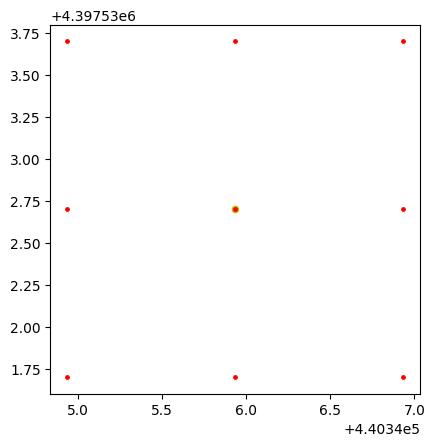

In [105]:
test_point = temp.iloc[0]
print(test_point)
# 测试；画图
_, ax = plt.subplots()
ax.set_aspect('equal')
x, y = test_point['origin_x'], test_point['origin_y']
ax.scatter(x, y, color='y', s=20)
for i in range(-1, 2):
    for j in range(-1, 2):
        ax.scatter(x + i, y + j, color='r', s=6)